In [ ]:
!pip install statsforecast utilsforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving daily_sales_french_bakery.csv to daily_sales_french_bakery (1).csv


In [ ]:
df = pd.read_csv('daily_sales_french_bakery.csv', parse_dates=['ds'])

In [ ]:
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [ ]:
df = df.groupby('unique_id').filter(lambda x: len(x) >=28)
df = df.drop(['unit_price'], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


In [ ]:
count_list = df.groupby('unique_id').size().reset_index(name='count')
count_list = count_list.sort_values(by='count', ascending=False)
count_list.head(25)

,unique_id,count
1,BAGUETTE,637
8,BOULE 400G,637
4,BANETTE,637
7,BOULE 200G,637
5,BANETTINE,637
13,CAFE OU EAU,637
14,CAMPAGNE,637
10,BRIOCHE,637
9,BOULE POLKA,637
21,COOKIE,637


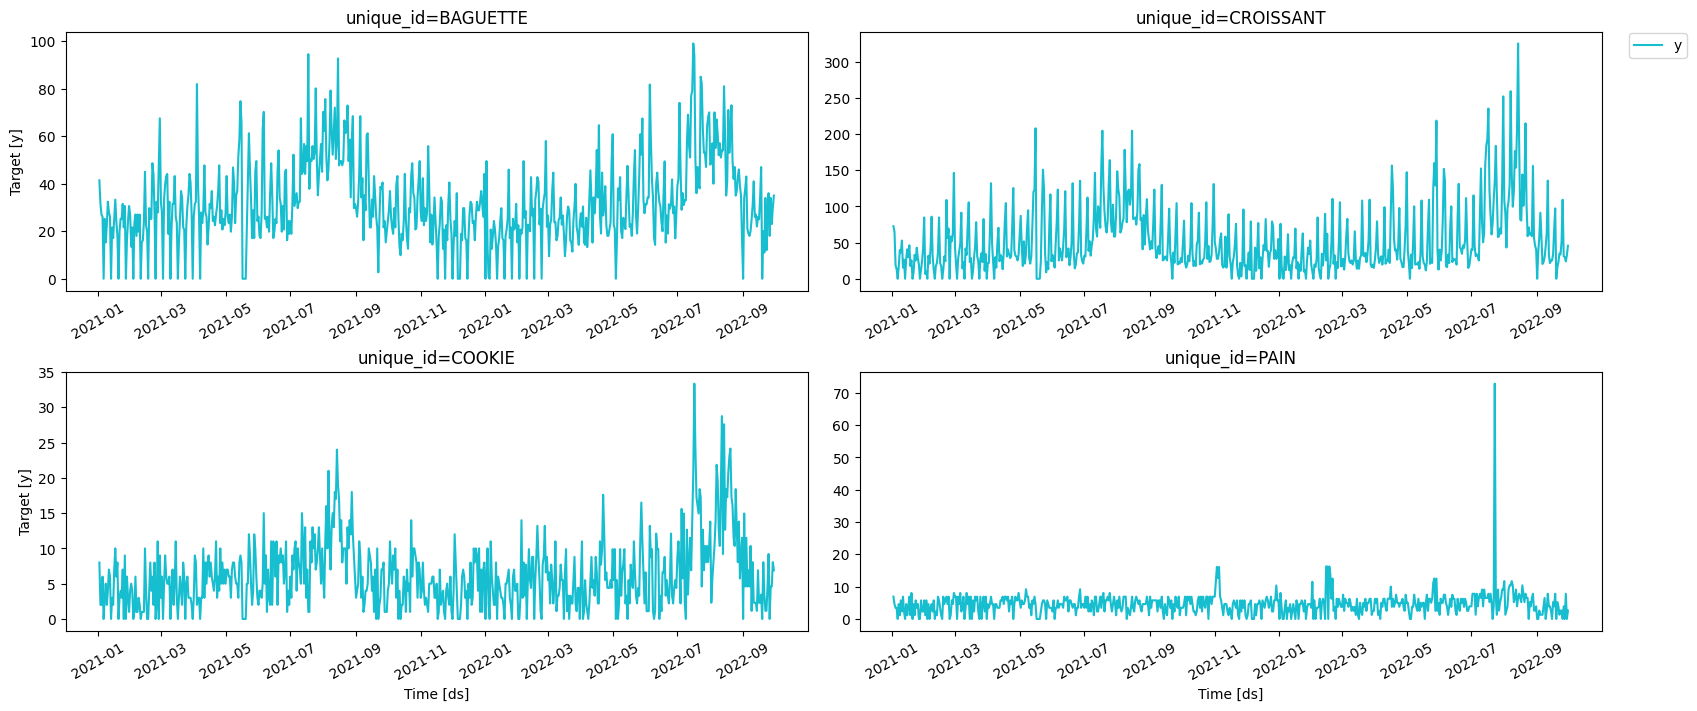

In [ ]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"])

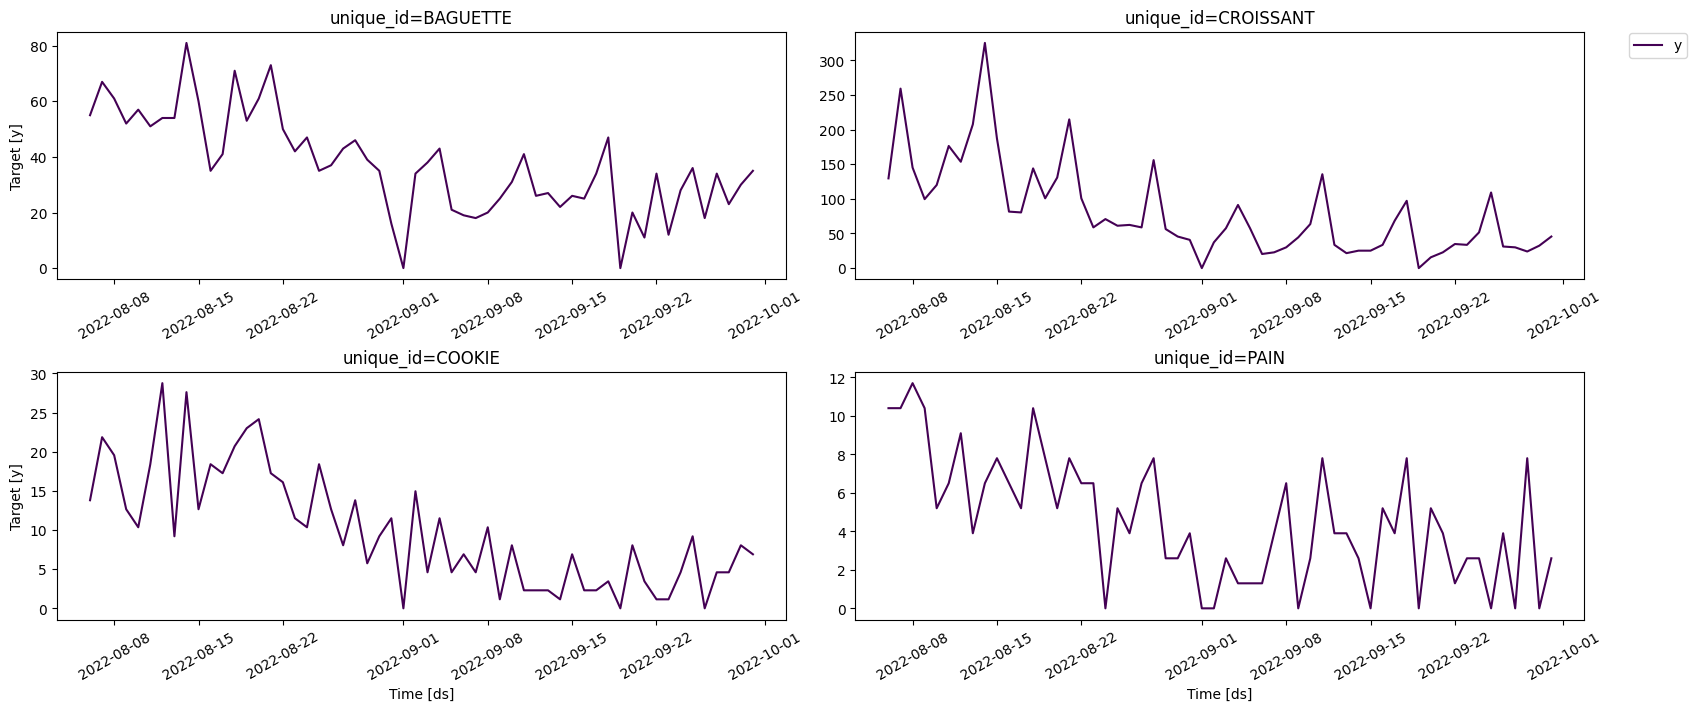

In [ ]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"], max_insample_length=56, palette='viridis')

In [ ]:
#Baseline Models

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [ ]:
from statsforecast import models
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq='D')
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [ ]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


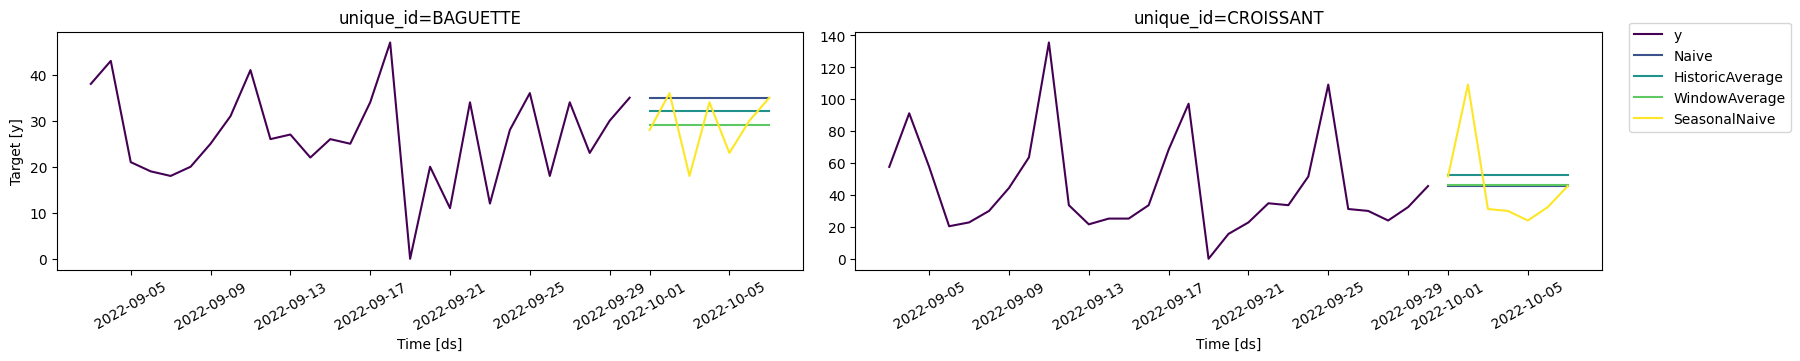

In [ ]:
plot_series(
    df=df,
    forecasts_df=preds,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28,
    palette='viridis')

In [ ]:
#Evaluate Baseline Models

In [ ]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [ ]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [ ]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [ ]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation.head()

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


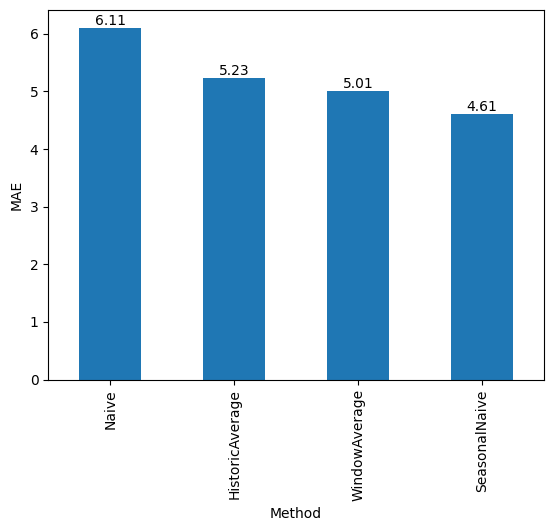

In [ ]:
ax = evaluation.iloc[0, 1:].plot(kind='bar')

ax.set_xlabel("Method")
ax.set_ylabel("MAE")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

In [ ]:
#AutoARIMA

In [ ]:
from statsforecast.models import AutoARIMA

In [ ]:
unique_ids = ["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"]

small_train = train[train['unique_id'].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias = "ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq='D')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)

arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,COOKIE,mae,3.240391,3.003856,4.600000,2.370680,3.426531,3.614286
2,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143
3,PAIN,mae,2.559211,2.893634,2.042857,3.137812,2.440816,3.342857


In [ ]:
arima_eval = arima_eval.drop(["unique_id"], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,7.429537,5.926429,10.317857,8.395655,7.997449,8.096429


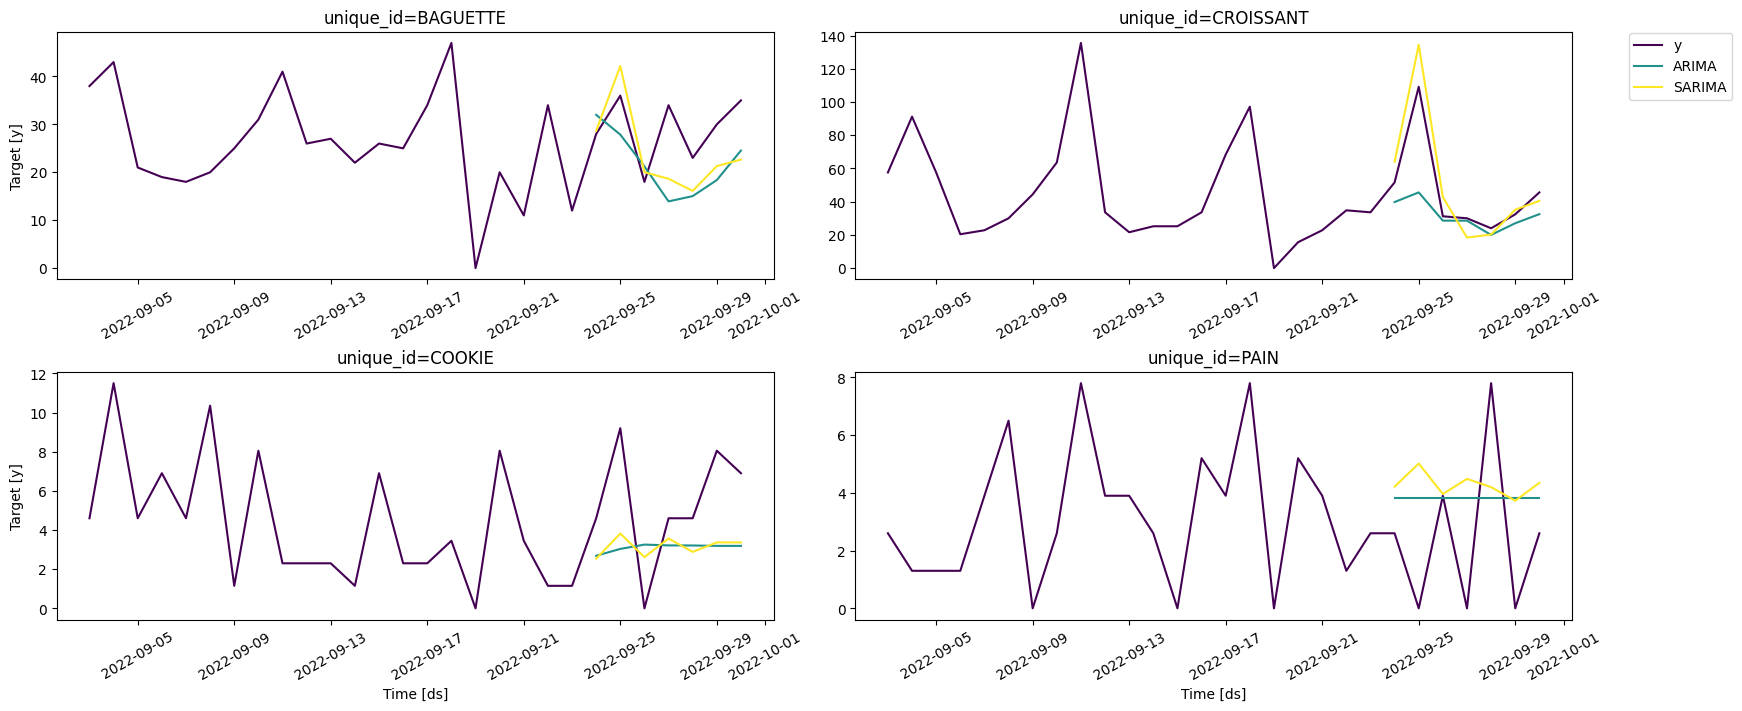

In [ ]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"],
    max_insample_length=28,
    palette='viridis'
)

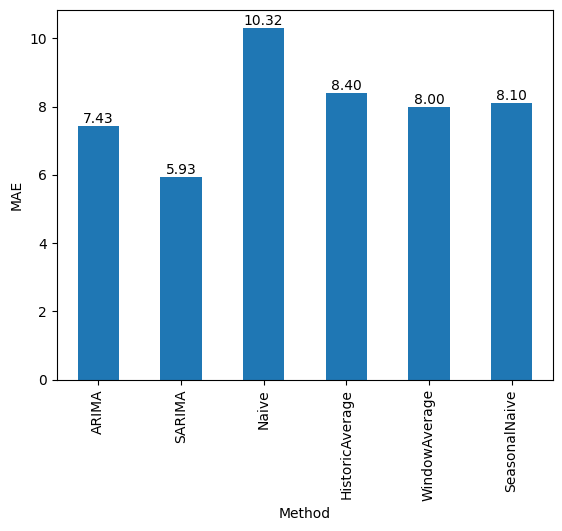

In [ ]:
axs = arima_eval.iloc[0, 1:].plot(kind='bar')

axs.set_xlabel("Method")
axs.set_ylabel("MAE")

for container in axs.containers:
    axs.bar_label(container, fmt="%.2f")

In [ ]:
#Cross-Validation

In [ ]:
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
    WindowAverage(window_size=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,WindowAverage,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,57.428571,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,57.428571,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,57.428571,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,57.428571,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,57.428571,47.785876,49.725278


In [ ]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae]
)

cv_eval = cv_eval.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
cv_eval

,metric,SeasonalNaive,WindowAverage,ARIMA,SARIMA
0,mae,12.751339,15.071747,12.548808,11.574902


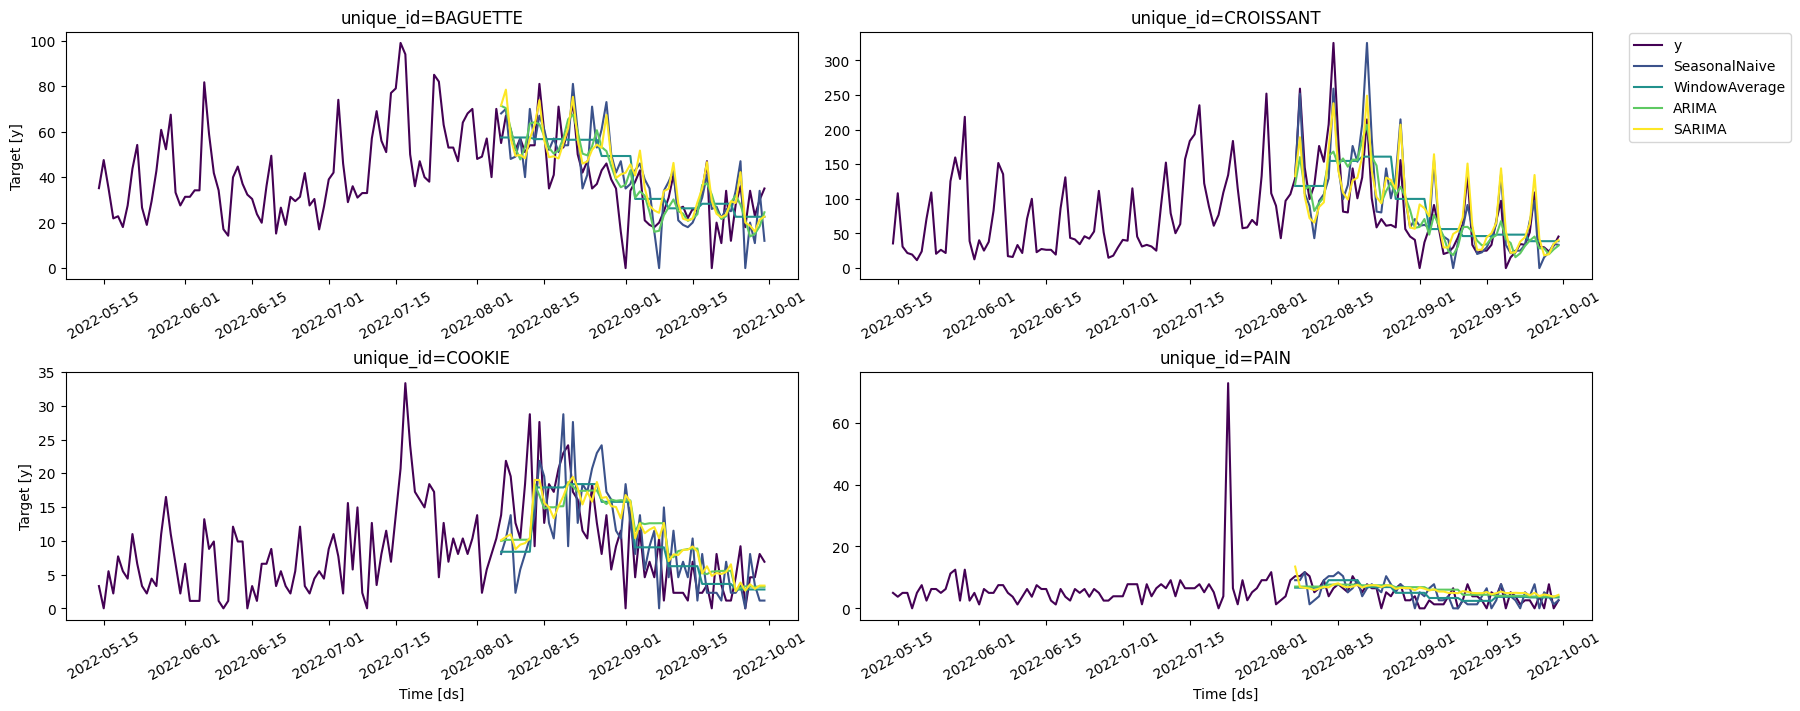

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"],
    max_insample_length=140,
    palette='viridis'
)

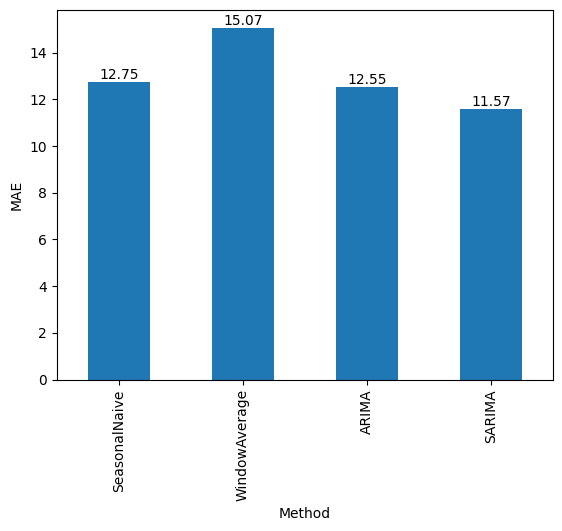

In [ ]:
axs = cv_eval.iloc[0, 1:].plot(kind='bar')

axs.set_xlabel("Method")
axs.set_ylabel("MAE")

for container in axs.containers:
    axs.bar_label(container, fmt="%.2f")

In [ ]:
#Forcasting Exogenous Features

In [ ]:
df = pd.read_csv('daily_sales_french_bakery.csv', parse_dates=['ds'])
df = df.groupby('unique_id').filter(lambda x: len(x) >=28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


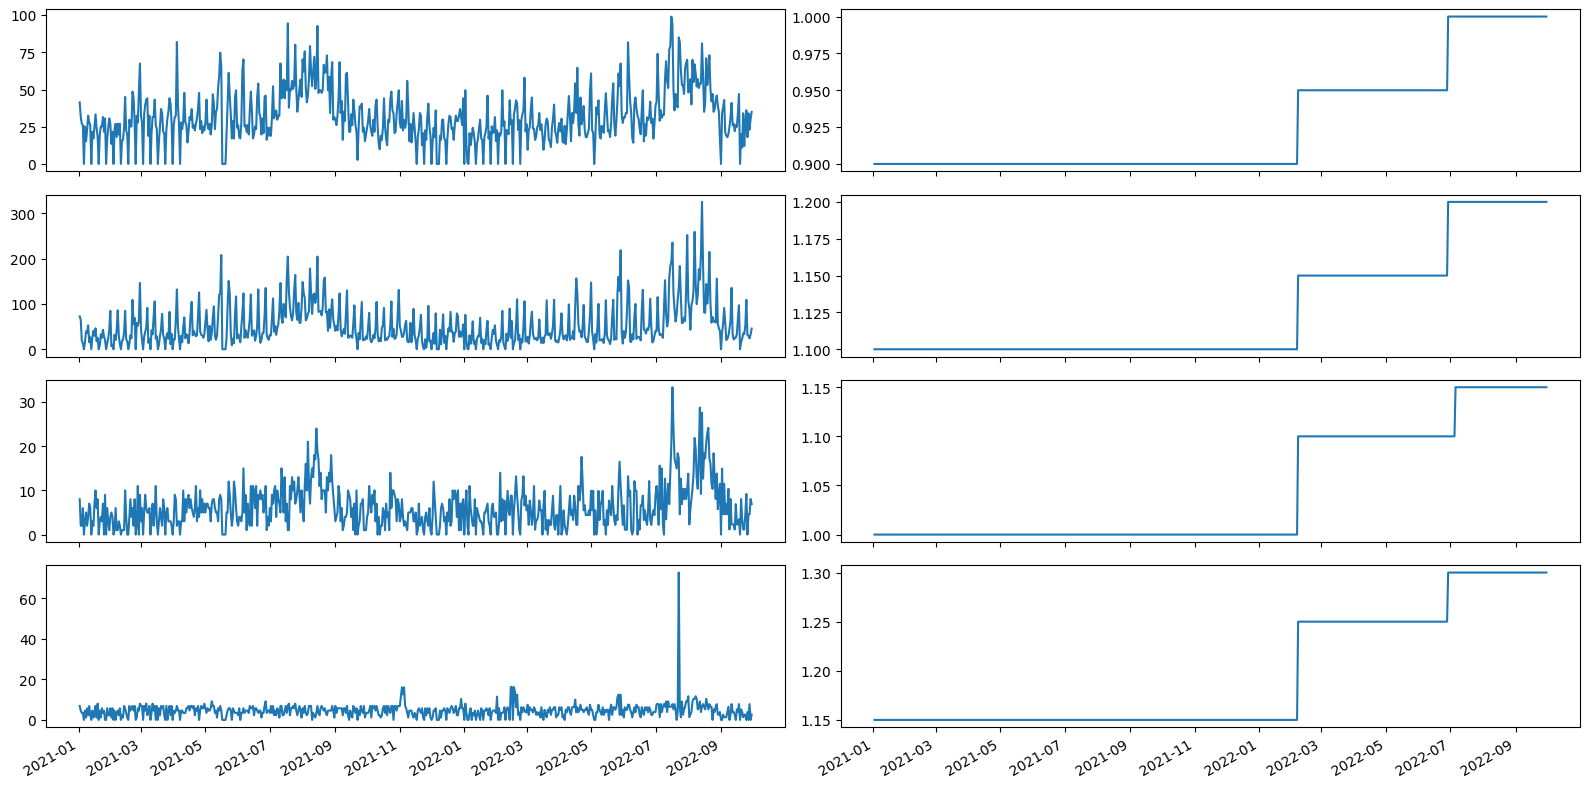

In [ ]:
baguette_plot_df = df[df['unique_id'] == 'BAGUETTE']
croissant_plot_df = df[df['unique_id'] == 'CROISSANT']
cookie_plot_df = df[df['unique_id'] == 'COOKIE']
pain_plot_df = df[df['unique_id'] == 'PAIN']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2, figsize=(16,8))

ax1.plot(baguette_plot_df['ds'], baguette_plot_df['y'])

ax2.plot(baguette_plot_df['ds'], baguette_plot_df['unit_price'])

ax3.plot(croissant_plot_df['ds'], croissant_plot_df['y'])

ax4.plot(croissant_plot_df['ds'], croissant_plot_df['unit_price'])

ax5.plot(cookie_plot_df['ds'], cookie_plot_df['y'])

ax6.plot(cookie_plot_df['ds'], cookie_plot_df['unit_price'])

ax7.plot(pain_plot_df['ds'], pain_plot_df['y'])

ax8.plot(pain_plot_df['ds'], pain_plot_df['unit_price'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [ ]:
uniqute_ids = ["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"]
small_df = df[df['unique_id'].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [ ]:
 futr_exog_df = test.drop(["y"], axis=1)
 futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [ ]:
#Define Model

models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)

# Predict with Exogenous Features

arima_exog_preds = sf.predict(h=horizon, X_df=futr_exog_df)

#Comparing SARIMA wihtout Exogenous Features

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(["unit_price"], axis=1))
arima_preds = sf.predict(h=horizon)

In [ ]:
test_df = test.merge(arima_exog_preds, on=["unique_id","ds"], how="left")\
              .merge(arima_preds,on=["unique_id","ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.00,1.00,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.00,1.00,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.00,1.00,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.00,1.00,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.00,1.00,16.468885,16.114925
5,BAGUETTE,2022-09-29,30.00,1.00,21.656726,21.288019
6,BAGUETTE,2022-09-30,35.00,1.00,23.101235,22.660124
7,COOKIE,2022-09-24,4.60,1.15,2.684752,2.535839
8,COOKIE,2022-09-25,9.20,1.15,4.072523,3.821148
9,COOKIE,2022-09-26,0.00,1.15,3.102786,2.615754


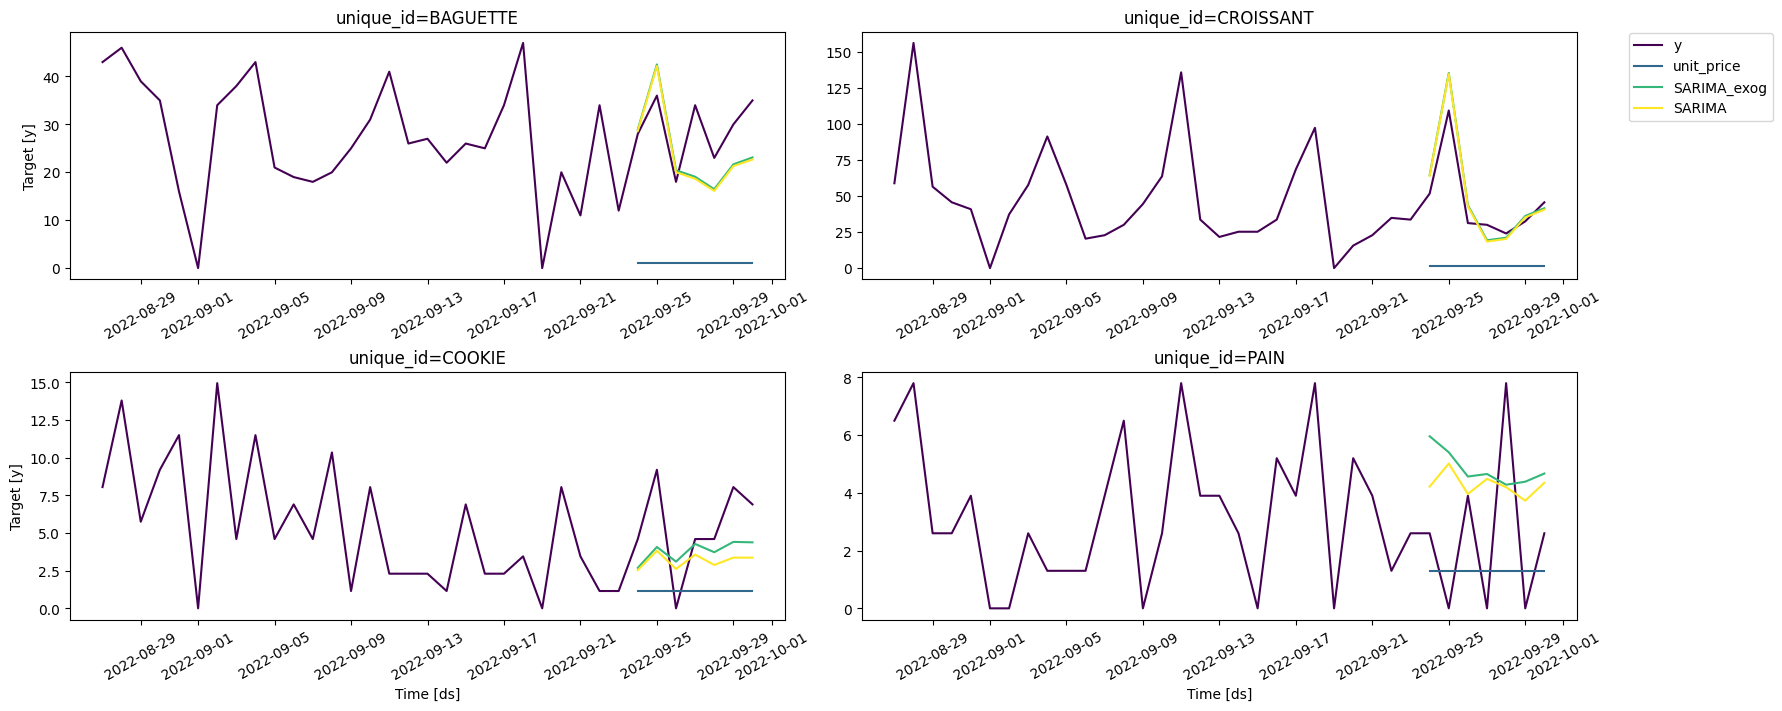

In [ ]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"],
    max_insample_length=28,
    palette='viridis'
)

In [ ]:
#Cross-Validation

models=[
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_exog_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [ ]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae]
)

cv_exog_eval = cv_exog_eval.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,11.572205


In [ ]:
#Creating Features from Timestamps

In [ ]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [ ]:
features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=["day","week", "month"])
]

small_exog_df, futr_exog_df = pipeline(
    df=small_df,
    features=features,
    freq="D",
    h=horizon
)

In [ ]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [ ]:
futr_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,COOKIE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,COOKIE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,COOKIE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [ ]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon, #7 Days
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae]
)

cv_time_exog_eval = cv_time_exog_eval.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_exog
0,mae,11.855539


Text(0.5, 1.0, 'Comparison of Models by MAE')

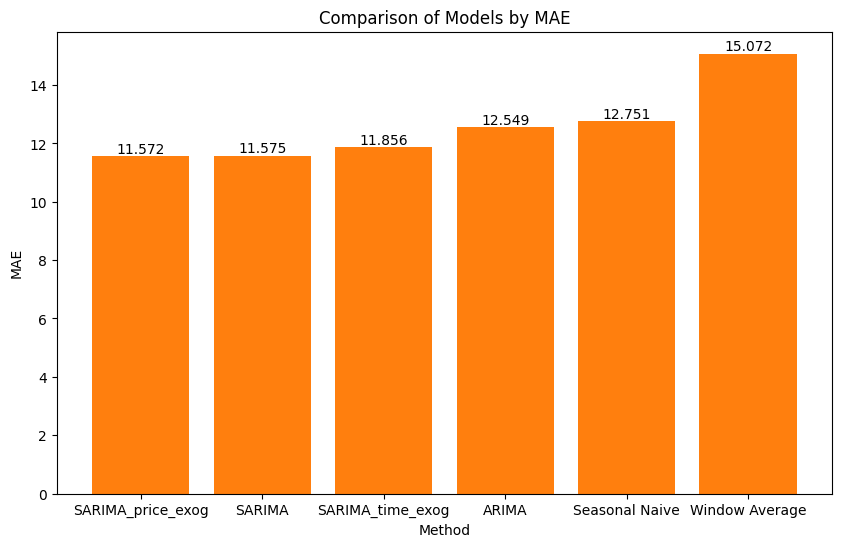

In [ ]:
methods=["ARIMA", "Seasonal Naive", "Window Average", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"]
values = [12.549, 12.751, 15.072, 11.575, 11.572, 11.856]

sorted_data=sorted(zip(methods, values), key=lambda x: x[1])
sorted_methods, sorted_values = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.bar(sorted_methods, sorted_values)

bars = plt.bar(sorted_methods, sorted_values)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Method")
plt.ylabel("MAE")
plt.title("Comparison of Models by MAE")

In [ ]:
#Prediction Intervals

In [ ]:
unique_ids = ["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [ ]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [ ]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog_price")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
prob_preds = sf.predict(h=horizon, X_df=test.drop(["y"], axis=1), level=[80, 90, 95])

In [ ]:
test_df = test.merge(prob_preds, on=["unique_id","ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog_price,SARIMA_exog_price-lo-95,SARIMA_exog_price-lo-90,SARIMA_exog_price-lo-80,SARIMA_exog_price-hi-80,SARIMA_exog_price-hi-90,SARIMA_exog_price-hi-95
0,BAGUETTE,2022-09-24,28.00,1.00,28.898898,8.622791,11.882653,15.641064,42.156732,45.915144,49.175006
1,BAGUETTE,2022-09-25,36.00,1.00,42.513264,20.818631,24.306554,28.327906,56.698621,60.719973,64.207896
2,BAGUETTE,2022-09-26,18.00,1.00,20.423976,-1.801164,1.772051,5.891738,34.956214,39.075902,42.649117
3,BAGUETTE,2022-09-27,34.00,1.00,19.066264,-3.530792,0.102217,4.290843,33.841685,38.030311,41.663320
4,BAGUETTE,2022-09-28,23.00,1.00,16.468885,-6.448317,-2.763838,1.484132,31.453637,35.701607,39.386086
5,BAGUETTE,2022-09-29,30.00,1.00,21.656726,-1.551032,2.180162,6.481989,36.831463,41.133290,44.864484
6,BAGUETTE,2022-09-30,35.00,1.00,23.101235,-0.373745,3.400411,7.751771,38.450700,42.802060,46.576216
7,COOKIE,2022-09-24,4.60,1.15,2.684752,-4.924051,-3.700757,-2.290377,7.659881,9.070261,10.293555
8,COOKIE,2022-09-25,9.20,1.15,4.072523,-3.778345,-2.516133,-1.060884,9.205930,10.661180,11.923392
9,COOKIE,2022-09-26,0.00,1.15,3.102786,-5.088834,-3.771838,-2.253426,8.458999,9.977411,11.294406


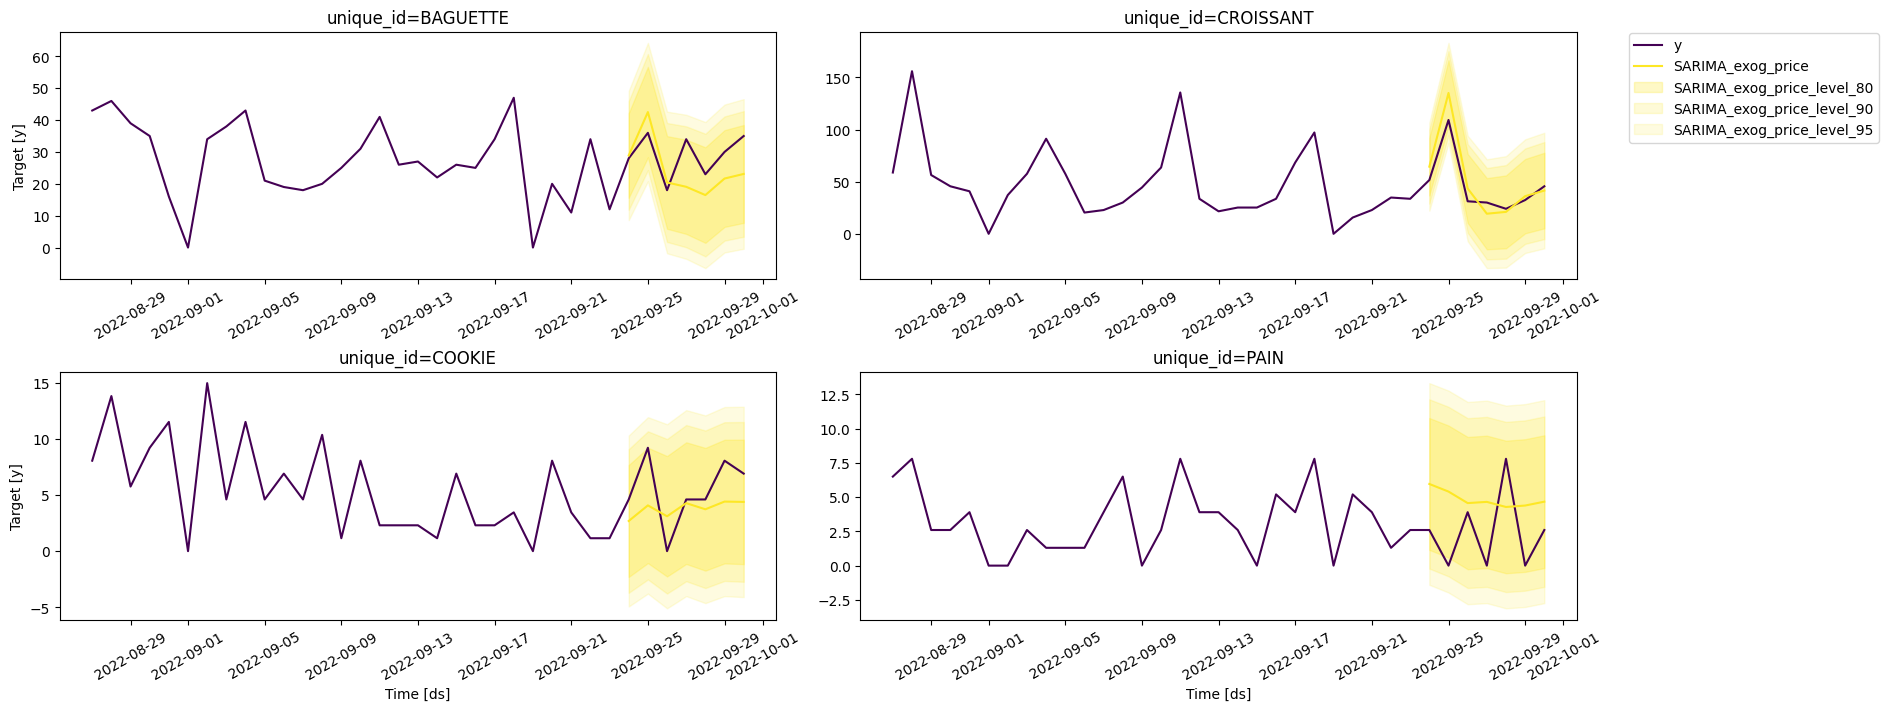

In [ ]:
plot_series(
    df=train,
    forecasts_df=test_df,
    ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"],
    max_insample_length=28,
    models=["SARIMA_exog_price"],
    level=[80, 90, 95],
    palette = "viridis")

In [ ]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog_price")
]

sf = StatsForecast(models=models, freq="D")

#Cross-Validation

cv_prob_df= sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit = True,
    level=[80, 90, 95]
)

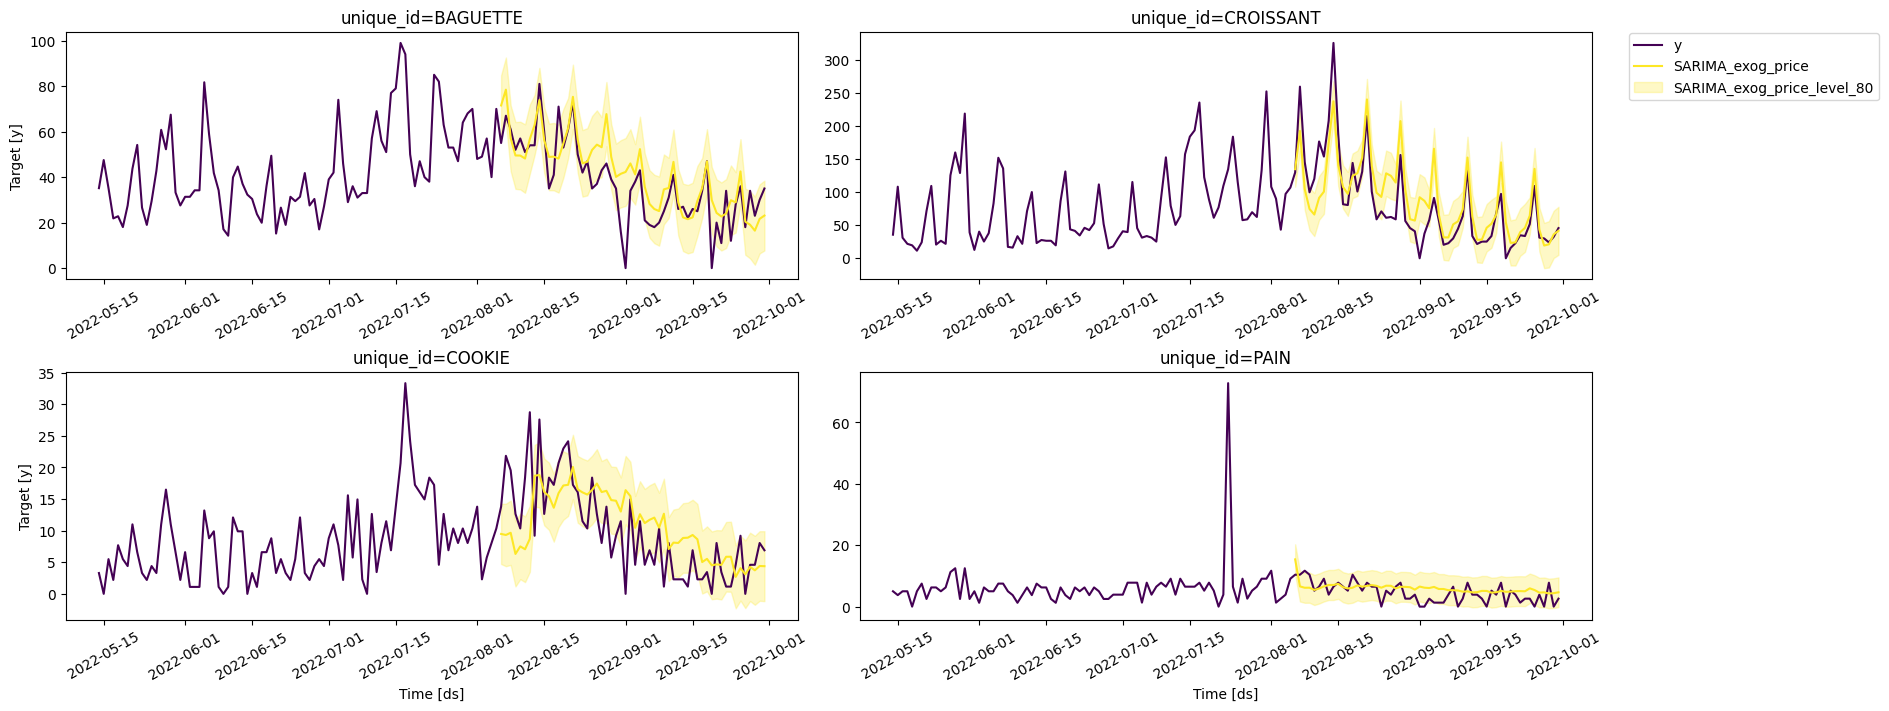

In [ ]:
plot_series(
    df=small_df,
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT", "COOKIE", "PAIN"],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

In [ ]:
#Evaluation Metrics - Continous Ranked Probability Score (CRPS)

In [ ]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog_price"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
final_cv_df= sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80])

In [ ]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog_price,SARIMA_exog_price-lo-80,SARIMA_exog_price-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [ ]:
temp_test_df =  small_df.groupby("unique_id").tail(7*8)
temp_train_df = small_df.drop(temp_test_df.index).reset_index(drop=True)

In [ ]:
models = ["SARIMA_exog_price", "SeasonalNaive"]
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality = 7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(["cutoff", "ds"], axis=1),
    metrics=metrics,
    models=models,
    train_df= temp_train_df,
    level=[80])

final_eval = final_eval.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
final_eval

,metric,SARIMA_exog_price,SeasonalNaive
0,mae,11.572205,12.751339
1,mape,0.602733,0.615239
2,mase,1.186427,1.325140
3,mse,409.580936,502.094665
4,rmse,14.928090,16.691898
5,scaled_crps,0.198658,0.228747
6,smape,0.248046,0.297963


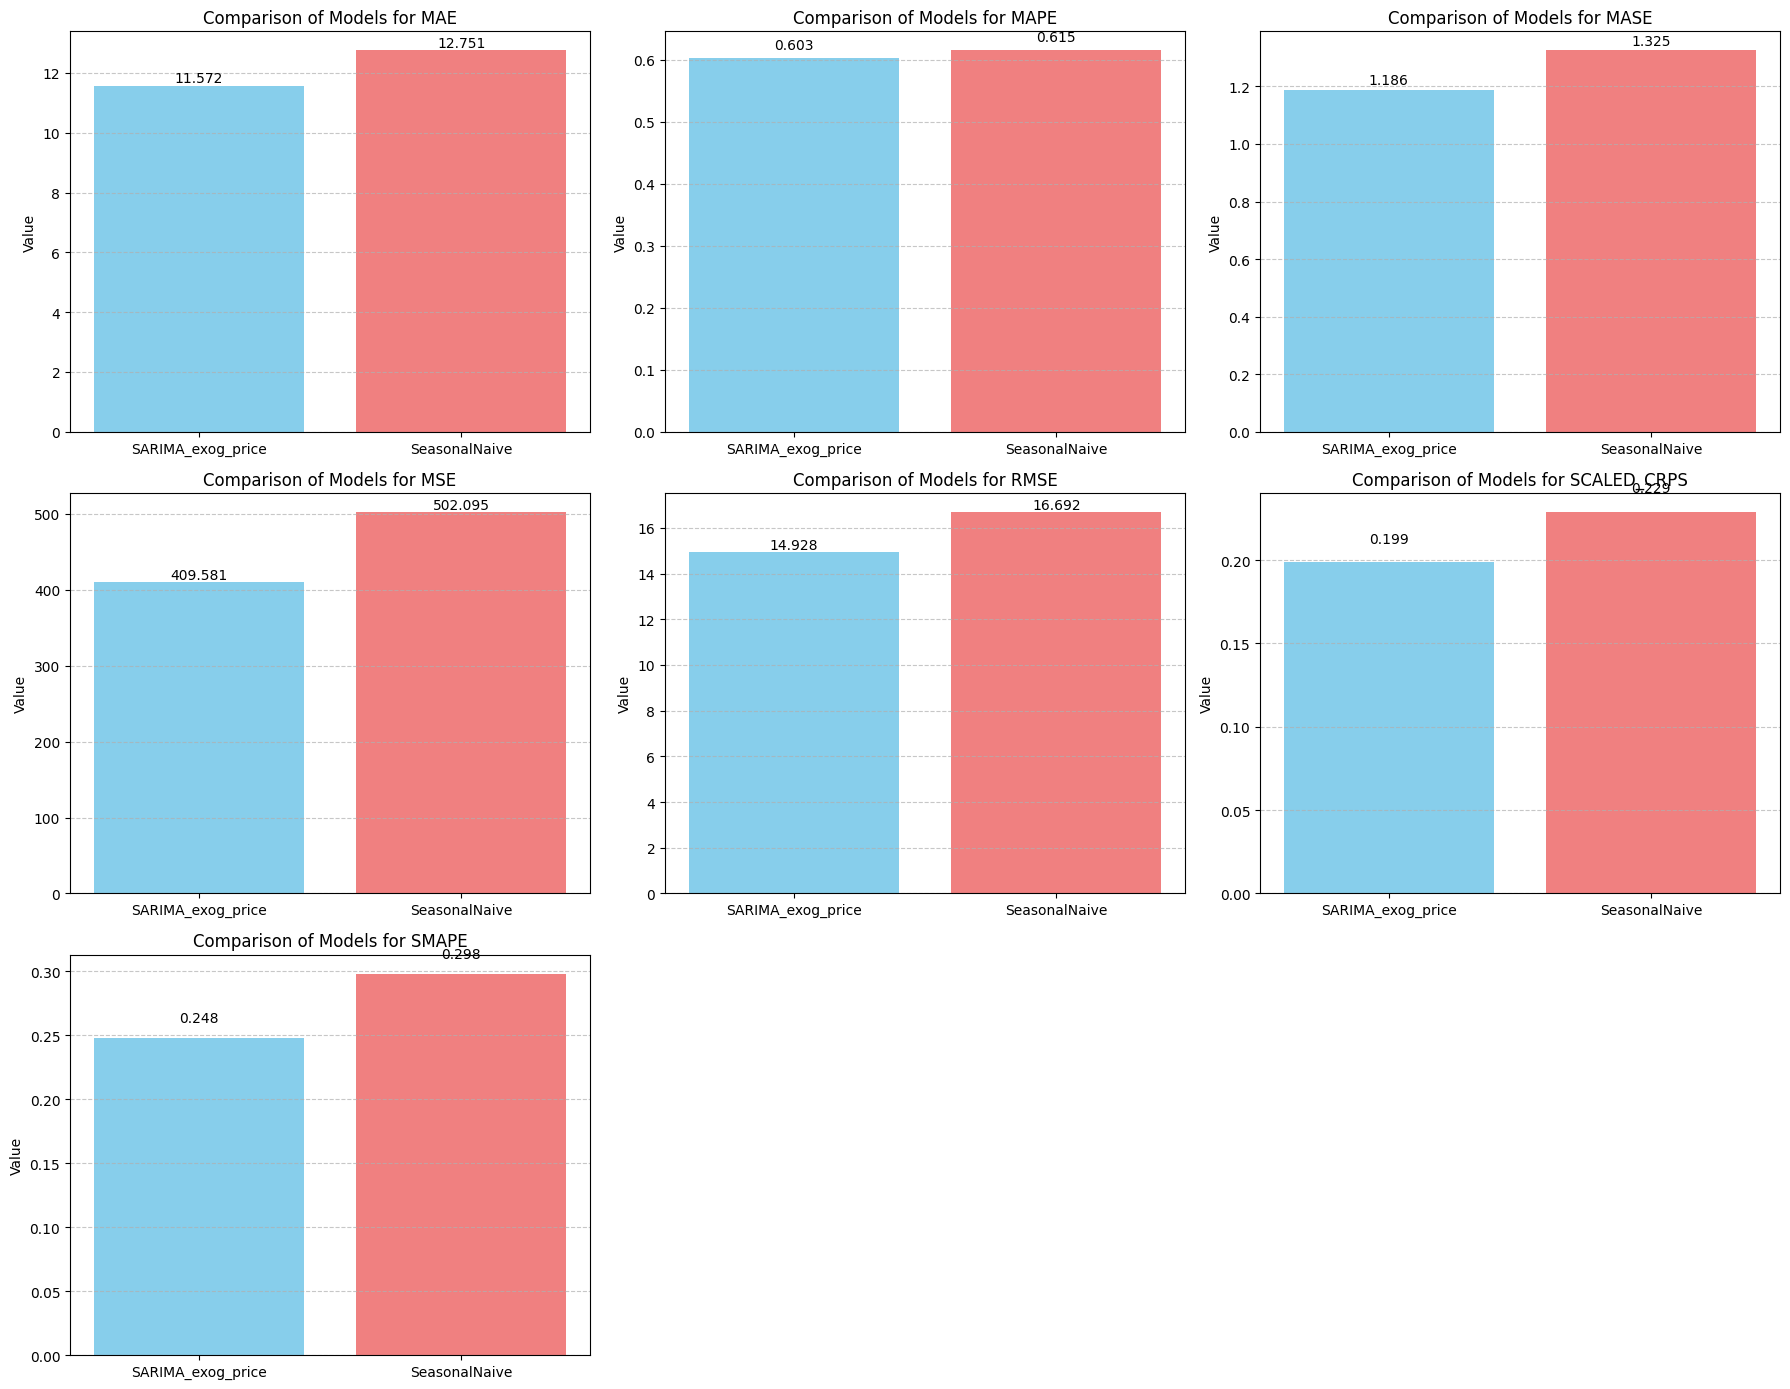

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, (metric_name, row) in enumerate(final_eval.set_index('metric').iterrows()):
    ax = axes[i]
    models = row.index.tolist()
    values = row.values.tolist()

    bars = ax.bar(models, values, color=['skyblue', 'lightcoral'])

    ax.set_ylabel('Value')
    ax.set_title(f'Comparison of Models for {metric_name.upper()}')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()